# Model Comparison: MinGRU vs Mamba vs Transformer

이 노트북에서는 4가지 시퀀스 모델의 학습 및 추론 성능을 비교합니다.

## 비교 모델

1. **MinGRU (Triton)**: Triton 커널 기반 최적화
2. **MinGRU (CUDA)**: CUDA C++ 커널 기반 최적화
3. **Mamba**: State Space Model with selective scan
4. **Transformer (LLaMA)**: Flash Attention 기반

## 비교 항목

- 학습 손실 (Training Loss)
- 검증 손실 (Validation Loss)
- 에포크당 학습 시간
- VRAM 사용량
- 파라미터 수

## 참고

- MinGRU: "Were RNNs All We Needed?" (arXiv:2410.01201)
- Mamba: "Mamba: Linear-Time Sequence Modeling" (arXiv:2312.00752)
- LLaMA: "LLaMA: Open and Efficient Foundation Language Models"

In [1]:
import sys
import os
import math
import time
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

PyTorch Version: 2.8.0+cu128
CUDA Available: True
GPU: NVIDIA A100 80GB PCIe
CUDA Version: 12.8


## Hyperparameters and Configuration

In [2]:
# Model Configuration (유사한 파라미터 수를 위한 설정)
SEQUENCE_LENGTH = 256
EMBEDDING_DIM = 64
HIDDEN_DIM = 128
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 256
DROPOUT = 0.1

# Mamba specific
STATE_SIZE = 16
D_CONV = 4
EXPAND = 2

# Training Configuration
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Data Preparation

TinyShakespeare 데이터셋을 사용한 문자 수준 언어 모델링

In [3]:
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)
    
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]
    
    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [4]:
# Load data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(
    text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT
)
vocab_size = len(chars)

print(f"Total characters: {len(text):,}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total characters: 1,115,394
Vocabulary size: 65
Train batches: 1961
Val batches: 218


## Common Modules

In [5]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization"""
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.float().pow(2).mean(-1, keepdim=True) + self.eps)
        return (x * rms).type_as(x) * self.weight


class SwiGLUFFN(nn.Module):
    """SwiGLU Feed-Forward Network (LLaMA style)"""
    def __init__(self, dim: int, hidden_dim: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(self.dropout(F.silu(self.w1(x)) * self.w3(x)))


class CausalConv1d(nn.Module):
    """Causal 1D Convolution"""
    def __init__(self, dim: int, kernel_size: int = 3):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(dim, dim, kernel_size, groups=dim)
        self.pointwise = nn.Conv1d(dim, dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.transpose(1, 2)
        x = F.pad(x, (self.kernel_size - 1, 0))
        x = self.pointwise(self.conv(x))
        return x.transpose(1, 2)

## Model 1 & 2: MinGRU (Triton / CUDA)

In [6]:
# Import MinGRU from backbone
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

from backbone import (
    MinGRUTriton, MinGRUCUDA,
    mingru_scan_triton, mingru_scan_cuda,
    is_triton_available, is_cuda_available,
)

print(f"Triton available: {is_triton_available()}")
print(f"CUDA kernel available: {is_cuda_available()}")

Triton available: True


W0202 16:11:04.481000 28521 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0202 16:11:04.481000 28521 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


CUDA kernel available: True


In [7]:
class MinGRUBlock(nn.Module):
    """MinGRU Block with Pre-Norm and Residual"""
    def __init__(self, d_model: int, dropout: float = 0.1, use_cuda: bool = True):
        super().__init__()
        self.use_cuda = use_cuda and is_cuda_available()
        
        if self.use_cuda:
            self.mingru = MinGRUCUDA(d_model, dropout=0.0)
        else:
            self.mingru = MinGRUTriton(d_model, dropout=0.0)
        
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.ffn = SwiGLUFFN(d_model, d_model * 2, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # MinGRU with residual
        residual = x
        x = self.norm1(x)
        x = self.mingru(x)
        x = residual + self.dropout(x)
        
        # FFN with residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + self.dropout(x)
        
        return x


class MinGRULM(nn.Module):
    """MinGRU Language Model"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int, 
                 dropout: float = 0.1, use_cuda: bool = True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.conv = CausalConv1d(d_model, kernel_size=3)
        
        self.layers = nn.ModuleList([
            MinGRUBlock(d_model, dropout, use_cuda) 
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # Weight tying

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.conv(h)
        
        for layer in self.layers:
            h = layer(h)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Model 3: Mamba (State Space Model)

In [8]:
# Check Mamba availability
try:
    from mamba_ssm import Mamba as MambaModule
    MAMBA_AVAILABLE = True
    print("Mamba SSM library available")
except ImportError:
    MAMBA_AVAILABLE = False
    print("Mamba SSM library not available, using simplified version")

Mamba SSM library available


In [9]:
if MAMBA_AVAILABLE:
    class MambaBlock(nn.Module):
        """Mamba Block using official mamba-ssm"""
        def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
            super().__init__()
            self.norm = RMSNorm(d_model)
            self.mamba = MambaModule(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand,
            )
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            residual = x
            x = self.norm(x)
            x = self.mamba(x)
            return residual + self.dropout(x)
else:
    # Simplified Mamba without selective scan
    class MambaBlock(nn.Module):
        """Simplified Mamba Block (without mamba-ssm)"""
        def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
            super().__init__()
            d_inner = d_model * expand
            self.norm = RMSNorm(d_model)
            self.in_proj = nn.Linear(d_model, d_inner * 2, bias=False)
            self.conv = nn.Conv1d(d_inner, d_inner, d_conv, groups=d_inner, padding=d_conv-1)
            self.out_proj = nn.Linear(d_inner, d_model, bias=False)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            residual = x
            x = self.norm(x)
            xz = self.in_proj(x)
            x, z = xz.chunk(2, dim=-1)
            
            x = x.transpose(1, 2)
            x = self.conv(x)[:, :, :x.shape[2]]
            x = x.transpose(1, 2)
            x = F.silu(x) * z
            x = self.out_proj(x)
            return residual + self.dropout(x)


class MambaLM(nn.Module):
    """Mamba Language Model"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int,
                 d_state: int = 16, d_conv: int = 4, expand: int = 2, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.dropout_emb = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            MambaBlock(d_model, d_state, d_conv, expand, dropout)
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.dropout_emb(h)
        
        for layer in self.layers:
            h = layer(h)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Model 4: Transformer (LLaMA style with Flash Attention)

In [10]:
# Check Flash Attention availability
try:
    from flash_attn import flash_attn_func
    FLASH_AVAILABLE = True
    print("Flash Attention available")
except ImportError:
    FLASH_AVAILABLE = False
    print("Flash Attention not available, using standard attention")

Flash Attention available


In [11]:
def precompute_freqs_cis(dim: int, max_seq_len: int, theta: float = 10000.0, device: str = 'cuda'):
    """Precompute RoPE frequencies"""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2, device=device).float() / dim))
    t = torch.arange(max_seq_len, device=device)
    freqs = torch.outer(t, freqs)
    return torch.polar(torch.ones_like(freqs), freqs)


def apply_rotary_emb(x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """Apply rotary positional embeddings"""
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    freqs_cis = freqs_cis[:x.shape[1]].view(1, x.shape[1], 1, -1)
    x_rotated = x_complex * freqs_cis
    return torch.view_as_real(x_rotated).reshape(x.shape).type_as(x)


class TransformerAttention(nn.Module):
    """Multi-Head Attention with optional Flash Attention"""
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
        B, L, D = x.shape
        
        q = self.wq(x).view(B, L, self.n_heads, self.head_dim)
        k = self.wk(x).view(B, L, self.n_heads, self.head_dim)
        v = self.wv(x).view(B, L, self.n_heads, self.head_dim)
        
        # Apply RoPE
        q = apply_rotary_emb(q, freqs_cis)
        k = apply_rotary_emb(k, freqs_cis)
        
        if FLASH_AVAILABLE:
            # Flash Attention expects [B, L, n_heads, head_dim]
            out = flash_attn_func(q.half(), k.half(), v.half(), causal=True).float()
        else:
            # Standard attention
            q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
            mask = torch.triu(torch.ones(L, L, device=x.device), 1).bool()
            scores.masked_fill_(mask, float('-inf'))
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            out = torch.matmul(attn, v).transpose(1, 2)
        
        out = out.reshape(B, L, D)
        return self.wo(out)


class TransformerBlock(nn.Module):
    """Transformer Block (LLaMA style)"""
    def __init__(self, d_model: int, n_heads: int, ffn_dim: int, dropout: float = 0.1):
        super().__init__()
        self.attention = TransformerAttention(d_model, n_heads, dropout)
        self.ffn = SwiGLUFFN(d_model, ffn_dim, dropout)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
        # Attention with residual
        residual = x
        x = self.norm1(x)
        x = self.attention(x, freqs_cis)
        x = residual + self.dropout(x)
        
        # FFN with residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = residual + self.dropout(x)
        
        return x


class TransformerLM(nn.Module):
    """Transformer Language Model (LLaMA style)"""
    def __init__(self, vocab_size: int, d_model: int, n_layers: int, 
                 n_heads: int, ffn_dim: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, n_heads, ffn_dim, dropout)
            for _ in range(n_layers)
        ])
        
        self.norm = RMSNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight
        
        # Precompute RoPE
        self.register_buffer('freqs_cis', precompute_freqs_cis(
            d_model // n_heads, max_seq_len * 2, device='cuda'
        ))

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, None]:
        h = self.embedding(x)
        
        for layer in self.layers:
            h = layer(h, self.freqs_cis)
        
        h = self.norm(h)
        logits = self.lm_head(h)
        return logits, None

## Training and Evaluation Functions

In [12]:
def count_parameters(model):
    """Count trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    """Train for one epoch"""
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        losses.append(loss.item())
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', vram=f'{allocated:.0f}MB')
    
    return np.mean(losses), np.mean(vram_usage)


def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    losses = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append(loss.item())
    
    return np.mean(losses)


def train_model(model, model_name, train_loader, val_loader, device, epochs, lr):
    """Full training loop"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, fused=True)
    
    history = {
        'train_loss': [], 'val_loss': [], 
        'epoch_time': [], 'vram_usage': []
    }
    
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"Parameters: {count_parameters(model):,}")
    print(f"{'='*60}")
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        train_loss, vram = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        val_loss = validate(model, val_loader, criterion, device)
        
        epoch_time = time.time() - start_time
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epoch_time'].append(epoch_time)
        history['vram_usage'].append(vram)
        
        print(f"Epoch {epoch}/{epochs} | "
              f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
              f"Time: {epoch_time:.1f}s | VRAM: {vram:.0f}MB")
    
    return history

## Create Models and Compare

In [13]:
# Create all models
models = {}

# MinGRU (Triton)
models['MinGRU-Triton'] = MinGRULM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    dropout=DROPOUT, use_cuda=False
).to(device)

# MinGRU (CUDA)
models['MinGRU-CUDA'] = MinGRULM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    dropout=DROPOUT, use_cuda=True
).to(device)

# Mamba
models['Mamba'] = MambaLM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    d_state=STATE_SIZE, d_conv=D_CONV, expand=EXPAND, dropout=DROPOUT
).to(device)

# Transformer
models['Transformer'] = TransformerLM(
    vocab_size=vocab_size, d_model=HIDDEN_DIM, n_layers=NUM_LAYERS,
    n_heads=NUM_HEADS, ffn_dim=FFN_DIM, max_seq_len=SEQUENCE_LENGTH, dropout=DROPOUT
).to(device)

# Print parameter counts
print("\nModel Parameter Counts:")
print("-" * 40)
for name, model in models.items():
    print(f"{name}: {count_parameters(model):,}")


Model Parameter Counts:
----------------------------------------
MinGRU-Triton: 551,808
MinGRU-CUDA: 551,808
Mamba: 474,880
Transformer: 664,832


In [14]:
# Train all models
results = {}

for name, model in models.items():
    torch.cuda.empty_cache()
    history = train_model(model, name, train_loader, val_loader, device, EPOCHS, LEARNING_RATE)
    results[name] = history


Training MinGRU-Triton
Parameters: 551,808


Epoch 1/20 | Train: 2.0097 | Val: 1.6298 | Time: 98.2s | VRAM: 49MB


Epoch 2/20 | Train: 1.4110 | Val: 1.5419 | Time: 95.8s | VRAM: 49MB


Epoch 3/20 | Train: 1.2871 | Val: 1.5158 | Time: 95.8s | VRAM: 49MB


Epoch 4/20 | Train: 1.2072 | Val: 1.5228 | Time: 96.2s | VRAM: 49MB


Epoch 5/20 | Train: 1.1531 | Val: 1.5194 | Time: 96.5s | VRAM: 49MB


Epoch 6/20 | Train: 1.1189 | Val: 1.5234 | Time: 96.3s | VRAM: 49MB


Epoch 7/20 | Train: 1.0973 | Val: 1.5322 | Time: 96.4s | VRAM: 49MB


Epoch 8/20 | Train: 1.0823 | Val: 1.5370 | Time: 96.3s | VRAM: 49MB


Epoch 9/20 | Train: 1.0709 | Val: 1.5404 | Time: 96.3s | VRAM: 49MB


Epoch 10/20 | Train: 1.0621 | Val: 1.5500 | Time: 96.2s | VRAM: 49MB


Epoch 11/20 | Train: 1.0550 | Val: 1.5569 | Time: 96.2s | VRAM: 49MB


Epoch 12/20 | Train: 1.0491 | Val: 1.5555 | Time: 96.2s | VRAM: 49MB


Epoch 13/20 | Train: 1.0440 | Val: 1.5695 | Time: 96.6s | VRAM: 49MB


Epoch 14/20 | Train: 1.0397 | Val: 1.5677 | Time: 96.3s | VRAM: 49MB


Epoch 15/20 | Train: 1.0358 | Val: 1.5675 | Time: 96.4s | VRAM: 49MB


Epoch 16/20 | Train: 1.0325 | Val: 1.5744 | Time: 96.4s | VRAM: 49MB


Epoch 17/20 | Train: 1.0293 | Val: 1.5696 | Time: 96.4s | VRAM: 49MB


Epoch 18/20 | Train: 1.0266 | Val: 1.5784 | Time: 96.3s | VRAM: 49MB


Epoch 19/20 | Train: 1.0241 | Val: 1.5784 | Time: 96.3s | VRAM: 49MB


Epoch 20/20 | Train: 1.0219 | Val: 1.5854 | Time: 96.3s | VRAM: 49MB

Training MinGRU-CUDA
Parameters: 551,808


Epoch 1/20 | Train: 1.9900 | Val: 1.6322 | Time: 94.3s | VRAM: 52MB


Epoch 2/20 | Train: 1.4019 | Val: 1.5592 | Time: 94.3s | VRAM: 52MB


Epoch 3/20 | Train: 1.2832 | Val: 1.5248 | Time: 94.5s | VRAM: 52MB


Epoch 4/20 | Train: 1.2050 | Val: 1.5188 | Time: 94.4s | VRAM: 52MB


Epoch 5/20 | Train: 1.1511 | Val: 1.5179 | Time: 94.5s | VRAM: 52MB


Epoch 6/20 | Train: 1.1176 | Val: 1.5299 | Time: 94.5s | VRAM: 52MB


Epoch 7/20 | Train: 1.0964 | Val: 1.5381 | Time: 94.3s | VRAM: 52MB


Epoch 8/20 | Train: 1.0821 | Val: 1.5543 | Time: 94.4s | VRAM: 52MB


Epoch 9/20 | Train: 1.0713 | Val: 1.5495 | Time: 94.4s | VRAM: 52MB


Epoch 10/20 | Train: 1.0627 | Val: 1.5545 | Time: 94.7s | VRAM: 52MB


Epoch 11/20 | Train: 1.0558 | Val: 1.5729 | Time: 94.5s | VRAM: 52MB


Epoch 12/20 | Train: 1.0500 | Val: 1.5695 | Time: 94.7s | VRAM: 52MB


Epoch 13/20 | Train: 1.0451 | Val: 1.5798 | Time: 94.5s | VRAM: 52MB


Epoch 14/20 | Train: 1.0408 | Val: 1.5707 | Time: 94.9s | VRAM: 52MB


Epoch 15/20 | Train: 1.0370 | Val: 1.5847 | Time: 94.9s | VRAM: 52MB


Epoch 16/20 | Train: 1.0338 | Val: 1.5938 | Time: 95.1s | VRAM: 52MB


Epoch 17/20 | Train: 1.0309 | Val: 1.5912 | Time: 95.0s | VRAM: 52MB


Epoch 18/20 | Train: 1.0281 | Val: 1.5899 | Time: 95.0s | VRAM: 52MB


Epoch 19/20 | Train: 1.0258 | Val: 1.6062 | Time: 95.1s | VRAM: 52MB


Epoch 20/20 | Train: 1.0236 | Val: 1.6038 | Time: 95.0s | VRAM: 52MB

Training Mamba
Parameters: 474,880


Epoch 1/20 | Train: 2.7921 | Val: 1.6983 | Time: 99.0s | VRAM: 53MB


Epoch 2/20 | Train: 1.4437 | Val: 1.5812 | Time: 99.1s | VRAM: 53MB


Epoch 3/20 | Train: 1.3100 | Val: 1.5316 | Time: 99.3s | VRAM: 53MB


Epoch 4/20 | Train: 1.2261 | Val: 1.5404 | Time: 99.2s | VRAM: 53MB


Epoch 5/20 | Train: 1.1698 | Val: 1.5437 | Time: 99.2s | VRAM: 53MB


Epoch 6/20 | Train: 1.1341 | Val: 1.5539 | Time: 99.0s | VRAM: 53MB


Epoch 7/20 | Train: 1.1115 | Val: 1.5686 | Time: 99.1s | VRAM: 53MB


Epoch 8/20 | Train: 1.0956 | Val: 1.5675 | Time: 99.2s | VRAM: 53MB


Epoch 9/20 | Train: 1.0833 | Val: 1.5663 | Time: 99.2s | VRAM: 53MB


Epoch 10/20 | Train: 1.0727 | Val: 1.5740 | Time: 99.2s | VRAM: 53MB


Epoch 11/20 | Train: 1.0634 | Val: 1.5704 | Time: 99.0s | VRAM: 53MB


Epoch 12/20 | Train: 1.0551 | Val: 1.5751 | Time: 98.5s | VRAM: 53MB


Epoch 13/20 | Train: 1.0477 | Val: 1.5875 | Time: 98.4s | VRAM: 53MB


Epoch 14/20 | Train: 1.0412 | Val: 1.5958 | Time: 98.8s | VRAM: 53MB


Epoch 15/20 | Train: 1.0353 | Val: 1.5971 | Time: 99.2s | VRAM: 53MB


Epoch 16/20 | Train: 1.0300 | Val: 1.6039 | Time: 99.2s | VRAM: 53MB


Epoch 17/20 | Train: 1.0255 | Val: 1.6052 | Time: 98.9s | VRAM: 53MB


Epoch 18/20 | Train: 1.0215 | Val: 1.6215 | Time: 98.8s | VRAM: 53MB


Epoch 19/20 | Train: 1.0178 | Val: 1.6132 | Time: 98.8s | VRAM: 53MB


Epoch 20/20 | Train: 1.0145 | Val: 1.6084 | Time: 98.7s | VRAM: 53MB

Training Transformer
Parameters: 664,832


Epoch 1/20 | Train: 2.5171 | Val: 1.7122 | Time: 92.3s | VRAM: 57MB


Epoch 2/20 | Train: 1.4786 | Val: 1.5684 | Time: 92.3s | VRAM: 57MB


Epoch 3/20 | Train: 1.3369 | Val: 1.5670 | Time: 92.6s | VRAM: 57MB


Epoch 4/20 | Train: 1.2592 | Val: 1.5568 | Time: 92.5s | VRAM: 57MB


Epoch 5/20 | Train: 1.2059 | Val: 1.5569 | Time: 92.5s | VRAM: 57MB


Epoch 6/20 | Train: 1.1694 | Val: 1.5635 | Time: 92.4s | VRAM: 57MB


Epoch 7/20 | Train: 1.1439 | Val: 1.5672 | Time: 92.5s | VRAM: 57MB


Epoch 8/20 | Train: 1.1260 | Val: 1.5664 | Time: 92.8s | VRAM: 57MB


Epoch 9/20 | Train: 1.1128 | Val: 1.5758 | Time: 92.6s | VRAM: 57MB


Epoch 10/20 | Train: 1.1026 | Val: 1.5655 | Time: 92.6s | VRAM: 57MB


Epoch 11/20 | Train: 1.0942 | Val: 1.5702 | Time: 92.5s | VRAM: 57MB


Epoch 12/20 | Train: 1.0872 | Val: 1.5856 | Time: 92.5s | VRAM: 57MB


Epoch 13/20 | Train: 1.0815 | Val: 1.5845 | Time: 92.7s | VRAM: 57MB


Epoch 14/20 | Train: 1.0765 | Val: 1.5916 | Time: 92.6s | VRAM: 57MB


Epoch 15/20 | Train: 1.0722 | Val: 1.5996 | Time: 92.6s | VRAM: 57MB


Epoch 16/20 | Train: 1.0685 | Val: 1.5926 | Time: 92.9s | VRAM: 57MB


Epoch 17/20 | Train: 1.0650 | Val: 1.6047 | Time: 92.7s | VRAM: 57MB


Epoch 18/20 | Train: 1.0620 | Val: 1.6060 | Time: 92.5s | VRAM: 57MB


Epoch 19/20 | Train: 1.0590 | Val: 1.6029 | Time: 92.7s | VRAM: 57MB


Epoch 20/20 | Train: 1.0565 | Val: 1.6131 | Time: 92.5s | VRAM: 57MB


## Results Visualization

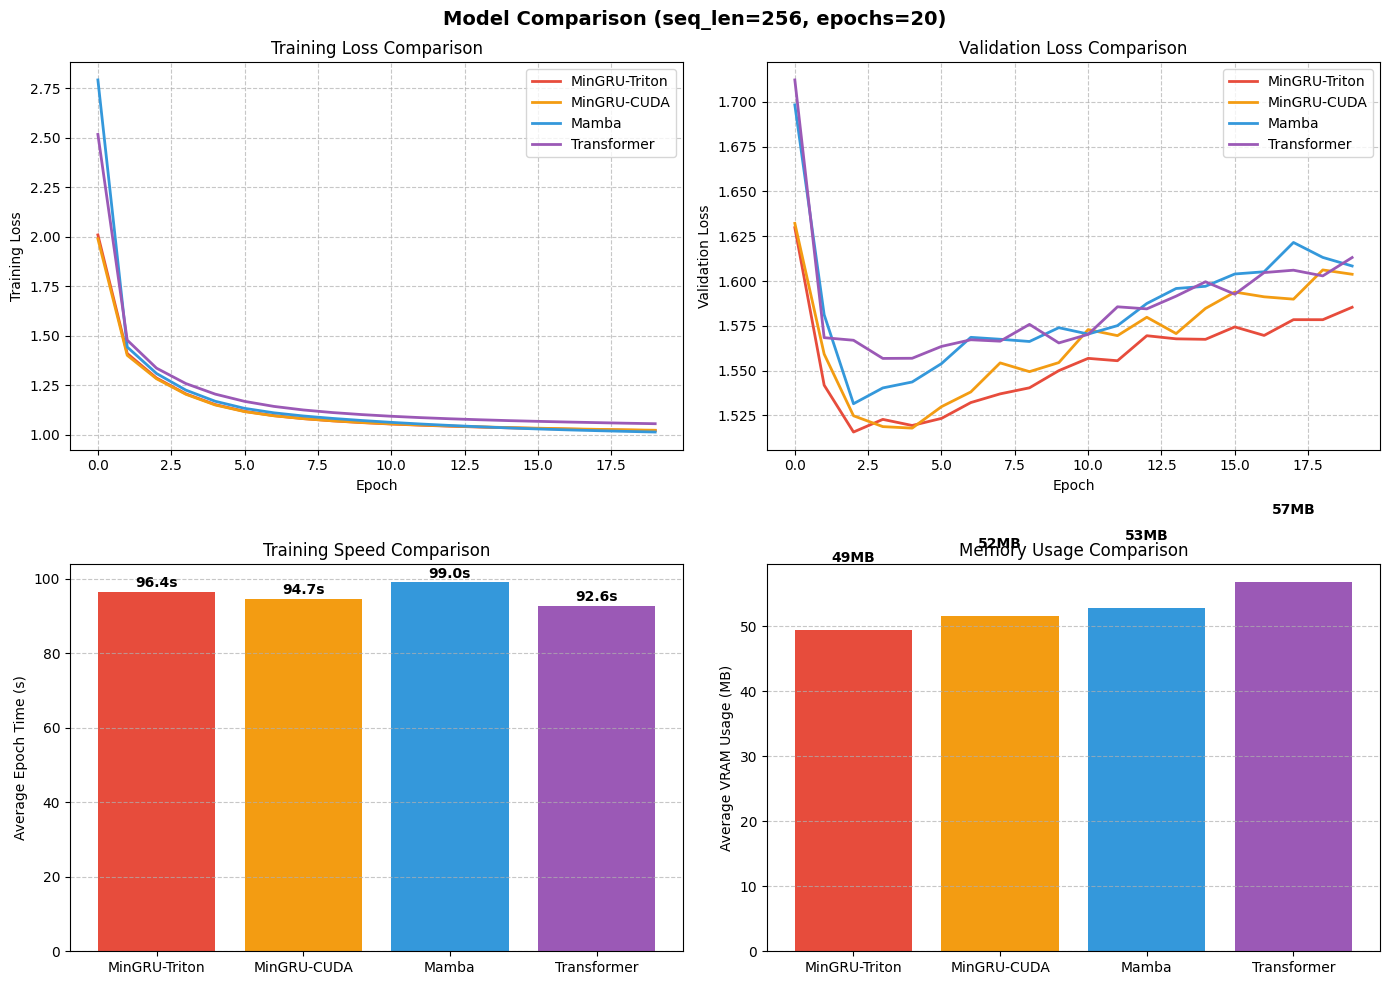

In [15]:
def plot_comparison(results):
    """Plot training comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = ['#e74c3c', '#f39c12', '#3498db', '#9b59b6']
    
    # Training Loss
    ax = axes[0, 0]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['train_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.set_title('Training Loss Comparison')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Validation Loss
    ax = axes[0, 1]
    for (name, history), color in zip(results.items(), colors):
        ax.plot(history['val_loss'], label=name, color=color, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss Comparison')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Epoch Time
    ax = axes[1, 0]
    names = list(results.keys())
    avg_times = [np.mean(h['epoch_time']) for h in results.values()]
    bars = ax.bar(names, avg_times, color=colors)
    ax.set_ylabel('Average Epoch Time (s)')
    ax.set_title('Training Speed Comparison')
    for bar, time in zip(bars, avg_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # VRAM Usage
    ax = axes[1, 1]
    avg_vram = [np.mean(h['vram_usage']) for h in results.values()]
    bars = ax.bar(names, avg_vram, color=colors)
    ax.set_ylabel('Average VRAM Usage (MB)')
    ax.set_title('Memory Usage Comparison')
    for bar, vram in zip(bars, avg_vram):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{vram:.0f}MB', ha='center', va='bottom', fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle(f'Model Comparison (seq_len={SEQUENCE_LENGTH}, epochs={EPOCHS})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()


plot_comparison(results)

In [16]:
# Summary Table
def print_summary(results, models):
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    
    data = []
    for name, history in results.items():
        data.append({
            'Model': name,
            'Parameters': f"{count_parameters(models[name]):,}",
            'Final Train Loss': f"{history['train_loss'][-1]:.4f}",
            'Final Val Loss': f"{history['val_loss'][-1]:.4f}",
            'Avg Epoch Time': f"{np.mean(history['epoch_time']):.1f}s",
            'Avg VRAM': f"{np.mean(history['vram_usage']):.0f}MB",
        })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))
    print("="*80)
    
    return df

summary_df = print_summary(results, models)
summary_df.to_csv('model_comparison_summary.csv', index=False)


SUMMARY
        Model Parameters Final Train Loss Final Val Loss Avg Epoch Time Avg VRAM
MinGRU-Triton    551,808           1.0219         1.5854          96.4s     49MB
  MinGRU-CUDA    551,808           1.0236         1.6038          94.7s     52MB
        Mamba    474,880           1.0145         1.6084          99.0s     53MB
  Transformer    664,832           1.0565         1.6131          92.6s     57MB


## Text Generation Test

In [17]:
def generate_text(model, start_text, max_length=200):
    """Generate text from model"""
    model.eval()
    current_text = start_text
    
    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, _ = model(x)
            probs = F.softmax(output[0, -1], dim=0)
            next_idx = torch.multinomial(probs, 1).item()
            current_text += idx_to_char[next_idx]
    
    return current_text


# Generate from each model
start_text = "ROMEO: "
print("\nText Generation Samples:")
print("="*60)

for name, model in models.items():
    generated = generate_text(model, start_text, max_length=150)
    print(f"\n[{name}]")
    print("-"*40)
    print(generated[:200])


Text Generation Samples:

[MinGRU-Triton]
----------------------------------------
ROMEO: hhake way'd to me, and speed all own!
Two and i' the city that way there are nursed by some suit!

JULIET:
O, no! o light, for thy hand! Now is my fac

[MinGRU-CUDA]
----------------------------------------
ROMEO: the Welshmen, now 'tis then, resign thy shore;
Rereing dead, why and my joy I am would burn,
To exclaim your seems dispatch, so much matter joy,
And t

[Mamba]
----------------------------------------
ROMEO: nay, gets here's what herd; some men is now.

Servant:
O, but a faithless lady! a thing! thy broad
Stands sink, he thinks the work of consortals,
And 

[Transformer]
----------------------------------------
ROMEO: I am, Northumberland;
For you, my lord; and all the churchyard
How I know the fault are one to light:
But I would grant you, sir, 'tis deceived;
And w
